In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

import allen_v1dd.stimulus_analysis.analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups, get_roi_id

at.set_stylesheet()
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")

%load_ext autoreload
%autoreload 2

(-1.0516229526090095, 1.0976963310766195, -1.1, 1.1)

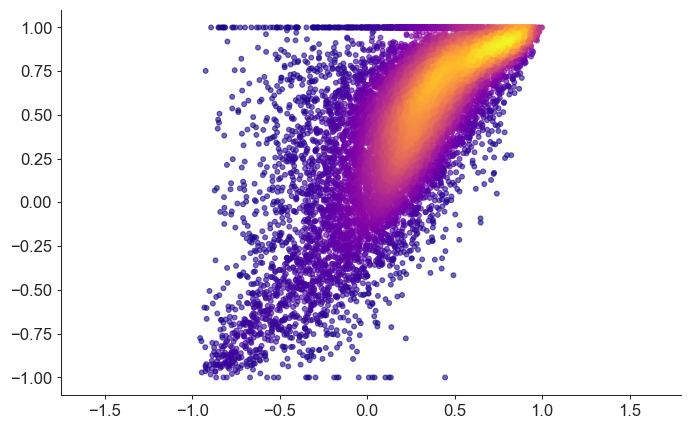

In [37]:
x, y = [], []

for group in iter_plane_groups(filter=dict(column=[2, 3, 4, 5])):
    dgw_responsive = group["drifting_gratings_windowed"]["frac_responsive_trials"][()] >= 0.5
    dgf_responsive = group["drifting_gratings_full"]["frac_responsive_trials"][()] >= 0.5
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()] & (dgw_responsive | dgf_responsive)
    x.extend(group["ssi"]["ssi_running_avg_at_pref_sf"][inclusion])
    y.extend(group["ssi"]["ssi_running"][inclusion])
at.density_scatter(x, y)
# plt.scatter(x, y)
plt.axis("equal")

In [111]:
df = []

for group in iter_plane_groups(filter=dict(column=[1])):
# for group in iter_plane_groups(filter=dict(column=[2, 3, 4, 5])):
    dgw = group["drifting_gratings_windowed"]
    dgf = group["drifting_gratings_full"]
    dgw_responsive = dgw["frac_responsive_trials"][()] >= 0.25
    dgf_responsive = dgf["frac_responsive_trials"][()] >= 0.25
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()] & (dgw_responsive | dgf_responsive)
    ssi = group["ssi"]["ssi_avg_at_pref_sf"][()]
    ssi_run = group["ssi"]["ssi_running_avg_at_pref_sf"][()]
    ssi_stat = group["ssi"]["ssi_stationary_avg_at_pref_sf"][()]
    # ssi = group["ssi"]["ssi"][()]
    # ssi_run = group["ssi"]["ssi_running"][()]
    # ssi_stat = group["ssi"]["ssi_stationary"][()]
    mouse = group.attrs["mouse"]
    column = group.attrs["column"]
    depth = group.attrs["plane_depth_microns"]
    # dgw_osi = dgw["osi_perm_test"][()]
    # dgf_osi = dgf["osi_perm_test"][()]
    dgw_osi = dgw["osi"][()]
    dgf_osi = dgf["osi"][()]

    for roi in np.where(inclusion)[0]:
        df.append(dict(
            mouse = mouse,
            column = column,
            roi_id = get_roi_id(group, roi),
            depth = depth,
            is_dgw_responsive = dgw_responsive[roi],
            is_dgf_responsive = dgf_responsive[roi],
            ssi = ssi[roi],
            ssi_run = ssi_run[roi],
            ssi_stat = ssi_stat[roi],
            # dgw_osi = dgw_osi[roi, 0] if dgw_osi[roi, 1] < 0.05 else np.nan,
            # dgf_osi = dgf_osi[roi, 0] if dgf_osi[roi, 1] < 0.05 else np.nan,
            dgw_osi = dgw_osi[roi],
            dgf_osi = dgf_osi[roi],
        ))

    
df = pd.DataFrame(df)
df

,mouse,column,roi_id,depth,is_dgw_responsive,is_dgf_responsive,ssi,ssi_run,ssi_stat,dgw_osi,dgf_osi
0,409828,1,M409828_11_0_89,50,True,True,0.036927,0.140181,-0.133195,0.371167,0.605655
1,409828,1,M409828_11_1_2,66,True,True,0.069366,0.193890,-0.038431,0.340322,0.512933
2,409828,1,M409828_11_1_4,66,True,False,-0.220513,-0.286421,-0.144224,0.286827,0.290500
3,409828,1,M409828_11_1_159,66,True,True,0.280201,0.296386,0.217335,0.330248,0.697710
4,409828,1,M409828_11_2_0,82,True,True,-0.601655,-0.671185,-0.753953,0.921747,0.965241
...,...,...,...,...,...,...,...,...,...,...,...
24327,438833,1,M438833_1d_0_55,675,True,True,0.100182,0.360700,0.001850,0.521107,0.387846
24328,438833,1,M438833_1d_0_61,675,True,True,0.040721,0.335868,-0.081220,0.472278,0.206699
24329,438833,1,M438833_1d_0_67,675,False,True,-0.186920,-0.010296,-0.193290,0.619397,0.577281
24330,438833,1,M438833_1d_0_69,675,True,True,-0.106245,-0.246935,0.008680,0.540139,0.585687


Text(0.5, 0.98, 'OSI values at different depths')

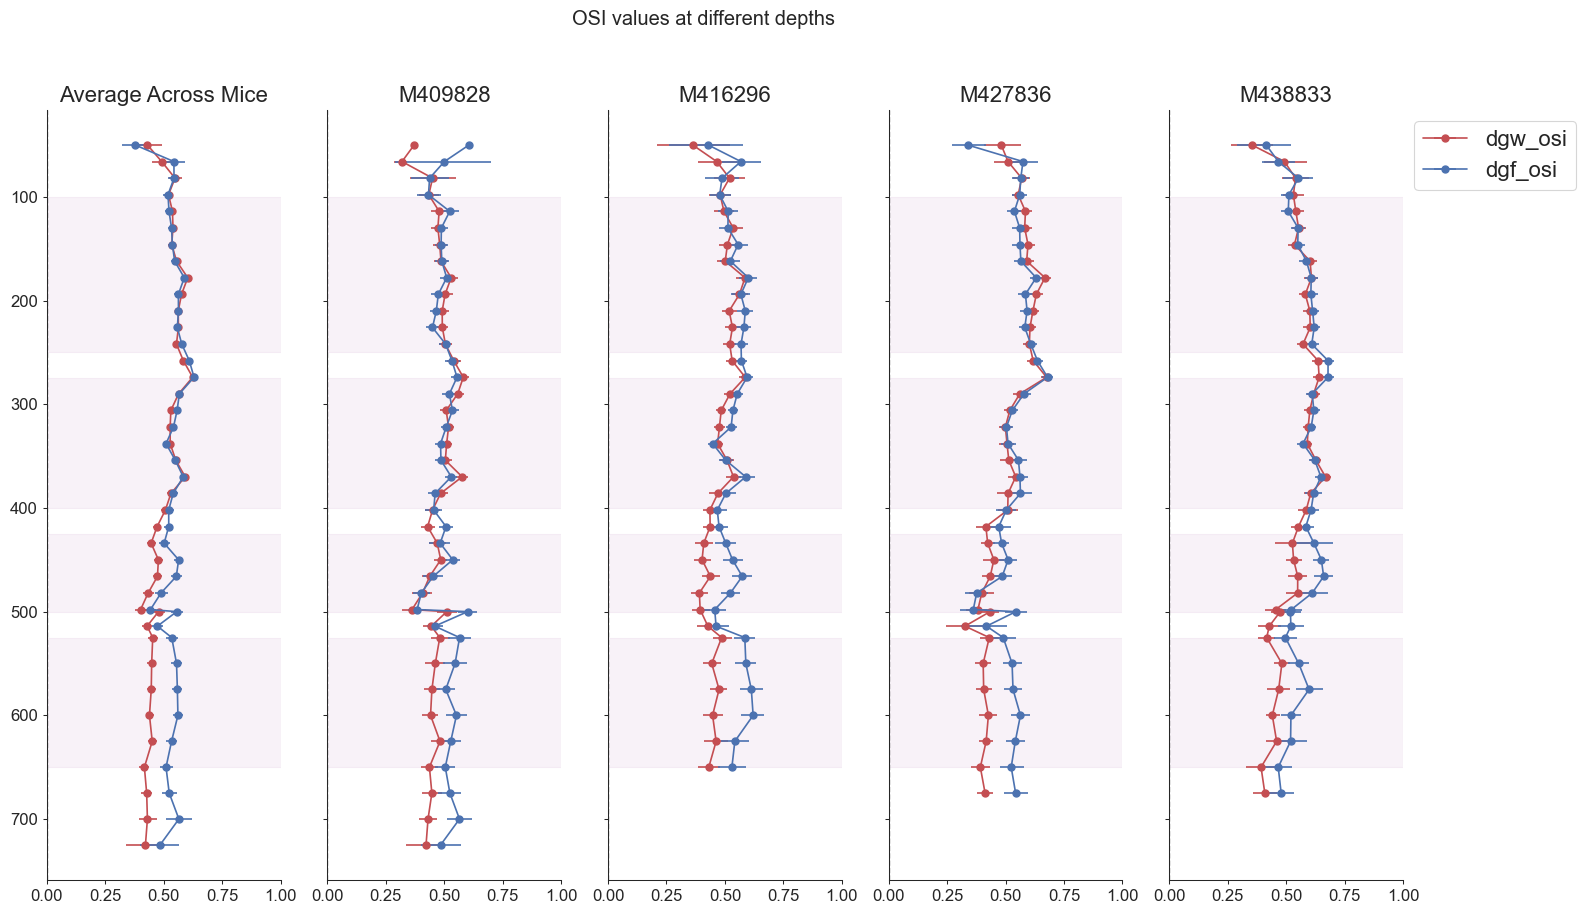

In [112]:
mice = df.mouse.unique()
fig, axs = plt.subplots(figsize=(3.5*(len(mice)+1), 10), ncols=len(mice)+1, sharey=True)

for i, ax in enumerate(axs):
    df_conf = df if i == 0 else df[df.mouse == mice[i-1]]
    # df_conf = df_conf[df_conf.is_dgw_responsive]
    df_conf = df_conf.groupby("depth").aggregate(
        dgw_osi_mean = pd.NamedAgg("dgw_osi", "mean"),
        dgf_osi_mean = pd.NamedAgg("dgf_osi", "mean"),
        dgw_osi_ci = pd.NamedAgg("dgw_osi", lambda data: tuple(sns.utils.ci(sns.algorithms.bootstrap(data.astype(float), n_boot=1000)))),
        dgf_osi_ci = pd.NamedAgg("dgf_osi", lambda data: tuple(sns.utils.ci(sns.algorithms.bootstrap(data.astype(float), n_boot=1000))))
    ).reset_index()

    for col, color in (("dgw_osi", "r"), ("dgf_osi", "b")):
        x_vals = df_conf[f"{col}_mean"].values
        y_vals = df_conf["depth"].values
        ci = np.vstack(df_conf[f"{col}_ci"].values).T
        ci[0] = x_vals - ci[0] # lower error, relative to mean
        ci[1] = ci[1] - x_vals # upper error
        ax.errorbar(x=x_vals, y=y_vals, xerr=ci, color=color, label=col, marker=".", markersize=10)

    if i == len(mice):
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes, fontsize=16)
    ax.set_title(f"M{mice[i-1]}" if i > 0 else "Average Across Mice", fontsize=16)
    ax.invert_yaxis()
    ax.set_xlim(0, 1)
    ax.axvline(x=0, color="gray", linewidth=1, linestyle="dashed")

    for ymin, ymax in ((100, 250), (275, 400), (425, 500), (525, 650)):
        ax.axhspan(ymin=ymin, ymax=ymax, color="purple", alpha=0.05)


fig.suptitle("OSI values at different depths")

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


Text(0.5, 0.98, 'mean and 95% bootstrapped CI SSI values at different depths\nColumn 1 only (including 3P imaging data in deeper planes)')

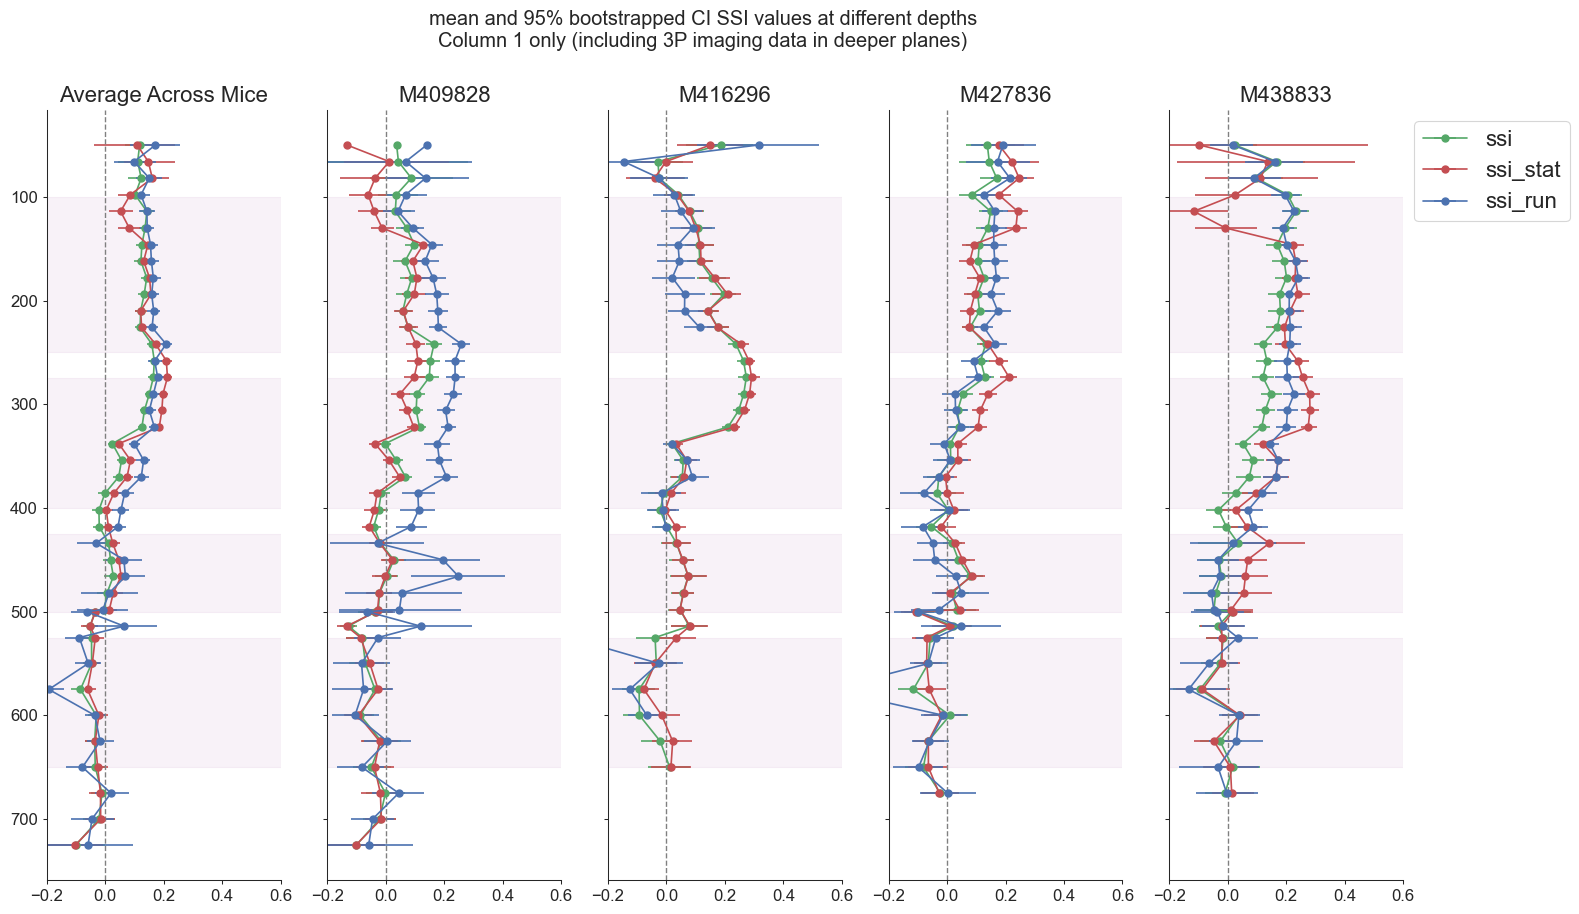

In [97]:
mice = df.mouse.unique()
fig, axs = plt.subplots(figsize=(3.5*(len(mice)+1), 10), ncols=len(mice)+1, sharey=True)

agg = {}
col_and_color = (("ssi", "g"), ("ssi_stat", "r"), ("ssi_run", "b"))
for col, _ in col_and_color:
    agg[f"{col}_mean"] = pd.NamedAgg(col, "mean")
    agg[f"{col}_ci"] = pd.NamedAgg(col, lambda data: tuple(sns.utils.ci(sns.algorithms.bootstrap(data.astype(float), n_boot=1000))))

for i, ax in enumerate(axs):
    df_conf = df if i == 0 else df[df.mouse == mice[i-1]]
    # df_conf = df_conf[df_conf.is_dgw_responsive]
    df_conf = df_conf.groupby("depth").aggregate(**agg).reset_index()

    for col, color in col_and_color:
        x_vals = df_conf[f"{col}_mean"].values
        y_vals = df_conf["depth"].values
        ci = np.vstack(df_conf[f"{col}_ci"].values).T
        ci[0] = x_vals - ci[0] # lower error, relative to mean
        ci[1] = ci[1] - x_vals # upper error
        ax.errorbar(x=x_vals, y=y_vals, xerr=ci, color=color, label=col, marker=".", markersize=10)

    if i == len(mice):
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes, fontsize=16)
    ax.set_title(f"M{mice[i-1]}" if i > 0 else "Average Across Mice", fontsize=16)
    ax.invert_yaxis()
    ax.set_xlim(-0.2, 0.6)
    ax.axvline(x=0, color="gray", linewidth=1, linestyle="dashed")

    for ymin, ymax in ((100, 250), (275, 400), (425, 500), (525, 650)):
        ax.axhspan(ymin=ymin, ymax=ymax, color="purple", alpha=0.05)


fig.suptitle("mean and 95% bootstrapped CI SSI values at different depths\nColumn 1 only (including 3P imaging data in deeper planes)")